# Assignment 1: Checkerboard Learning with Tent Activation

We want to train a shallow network that can approximate a function learned from input samples.

## Input Data
In our case, our input values are two-dimensional $\vec x\in\mathbb [-2,2]^2$, and the target value is a single number $t\in\{-1,1\}$, and it should represent a checkerboard.
Particularly, regions of size $1\times1$ shall be alternatingly assigned values $-1$ and $1$, such that two horizontally or vertically neighboring regions always have different targets.

We implement a function that returns the target value $t$ for a given input vector $\vec x\in\mathbb R^2$. 
We make sure that this function can handle samples in a batch, i.e., $\mathbf X \in \mathbb R^{B\times 2}$. 

In [8]:
import torch
import numpy as np
x = torch.distributions.Uniform(-2,2)
x


Uniform(low: -2.0, high: 2.0)

In [25]:
import torch
import numpy as np

# The input x has dimensions Bx2, where B is the batch size, and we have two dimensions in our input
def target(x):
  # The target value should be in dimension B or Bx1
  t = torch.zeros(x.shape[0])
  for i in range(x.shape[0]):
    if x[i,0] * x[i,1] > 0:
      t[i] = -1
    else:
      t[i] = 0
  # Which of the fields shall be considered 1 and which -1 is up to you, but they should represent a checker-board
  return t

### Sample Generation

We provide the function to generate a batch of samples following the input distribution.
This function will call the `target` function from task 1 and return the input and target tensors.

In [26]:
def batch(B, device = "cpu"):
    # generate B random data points in range [-2,2] in two dimensions.
    X = torch.distributions.Uniform(-2,2).sample([B,2]).to(device)
    # compute the targets for these samples
    T = target(X)
    # return both the inputs and the targets
    return X,T

### Visualization 1: Sample Visualization

We also provide a function to display the checkerboard samples.
You can run this cell to obtain a visualization, but this is not required.

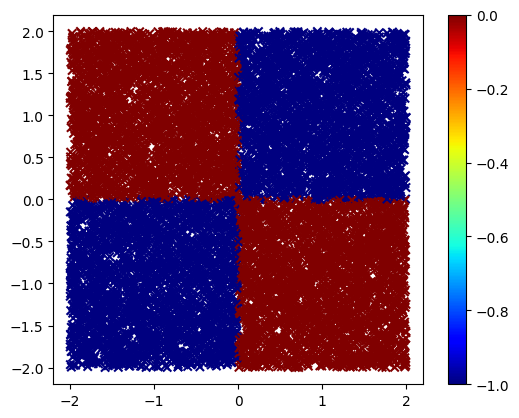

In [27]:
from matplotlib import pyplot

# obtain 10000 samples and their targets
samples, targets = batch(10000)

# plot samples and targets in a scatter plot
pyplot.scatter(samples[:,0], samples[:,1], marker="x", c = targets.numpy(), cmap="jet")
# make the plot more beautiful
pyplot.axis("square")
pyplot.colorbar()

## Tent Activation

Instead of using standard activation functions, we design our own `tent` activation that we use in our network:

$$\mathrm{tent}(a) = \begin{cases}1-a & \text{for } 0\leq a\leq 2 \\ 1+a & \text{for } -2 \leq a < 0\\ -1 & \text{elsewhere}\end{cases}$$

### Task (c): Tent Activation Function Implementation (6 Points)

Implement an autograd function in PyTorch that implements our activation function including its derivative. 
Implement the `forward` pass as well as the `backward` pass. 
Make sure that all functions work on batches of activations. 
Remember that the output of the `backward` pass is the partial derivative of the loss with respect to the inputs of the forward pass. 
How many values need to be returned in both functions? 


Notes:

* The expression $0<a<2$ can be implemented with the function `torch.logical_and(0 < a, a < 2)`.
* If the autograd function is too complicated, you can also implement the `tent` function by relying on the automatic differentiation (maximum 2 Points can be achieved through this implementation).
* If both of these are too complicated, you can also make use of a different activation function in your network implementation below.

In [11]:
# Alternative 1: Implement the tent activation function and rely on automatic differentiation
# You do not need to implement this function if you implement the Tent class below.
def tent(a):
    # compute the activation
    if  0 <= h <= 2:
        h = 1 - a
    elif -2 <= h <= 0:
        h = 1 + a
    else:
        h = -1
    return h

In [14]:
# The Tent class shall be used as activation function
# You need to implement the forward and the backward pass
class Tent(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a):
        # Compute the activation using the tent function as defined above
        h = tent(a)
        # save required information for the backward pass
        ctx.save_for_backward(h)
        # return the output(s) of the activation function
        return h.T
    
    # The input to this function is the partial derivative of the loss with respect to the output of the activation function
    def backward(ctx, dJ_dH):
        # compute the partial derivative(s) of the loss with respect to the input(s) of forward
        h = ctx.saved_tensors
        if  0 <= h <= 2:
            d_tent_a__d_a = -1
        elif -2 <= h <= 0:
            d_tent_a__d_a = 1
        else:
            d_tent_a__d_a = 0
        dJ_da = torch.Tensor(np.outer(dJ_dH, d_tent_a__d_a))
        # return the partial derivative(s)
        return 
    
# We will make use of this activation function.
# Please comment out this line (or do not run this cell) when you implement Alternative 1 above.
tent = Tent.apply

### Test case 1: Activation Function

We provide a test case for the implementation of the activation function.
It will test both the `forward` and the `backward` pass of the tent activation.
This test case shall work for both alternative implementations, the `Tent` class or the `tent` function.

In [15]:
# create some sample values
values = torch.tensor((-4.,-1.5,0.,0.5,1.3, 2.4), requires_grad=True)
# compute tent activation
result = tent(values)
# make sure that the output is correct
assert torch.all(torch.abs(result - torch.tensor((-1, -0.5, 1, 0.5, -0.3, -1))) < 1e-5)
print("Forward Computation Passed")

# compute the gradient with respect to the mean of the activations
j = torch.mean(result)
j.backward()

# assert that the output is correct. 
# The gradient for a=0 might differ based on the implementation
assert torch.all(torch.abs(values.grad - torch.tensor((0, 1/6, 1/6, -1/6, -1/6, 0))) < 1e-5) or\
       torch.all(torch.abs(values.grad - torch.tensor((0, 1/6, -1/6, -1/6, -1/6, 0))) < 1e-5) or\
       torch.all(torch.abs(values.grad - torch.tensor((0, 1/6, 0, -1/6, -1/6, 0))) < 1e-5)
print("Backward Computation Passed")

RecursionError: maximum recursion depth exceeded while calling a Python object

### Visualization 2: Activation Function Plot

We provide a visualization for your (forward) implementation of the `tent` function or `Tent` class.
You can run this cell, but it is not required.

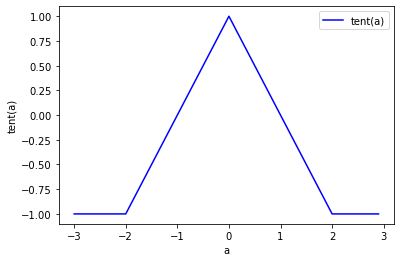

In [27]:
# create some input data
a = torch.arange(-3,3,0.1)
h = tent(a)

# plot the data
pyplot.plot(a, h, "b-", label="tent(a)")
# make the plot more beautiful
pyplot.xlabel("a")
pyplot.ylabel("tent(a)")
pyplot.legend()

## Network Implementation and Training

Our designed network should contain two fully-connected layers, with a reasonable hidden layer dimension of $K$ neurons, and solely `Tent` activations.
The output should be restricted to be inside the range of $-1\leq y \leq 1$.
We train our network with batches of $B=1000$ samples, using stochastic gradient descent with an appropriate learning rate $\eta$.
We need to select an appropriate loss function.


### Task (d): Shallow Network Implementation (3 Points)

Implement and instantiate a two-layer fully-connected network in `pytorch` with $D=2$ inputs, $O=1$ outputs and a reasonable number of hidden units $K$. 
Make use of the `tent` activation function whenever appropriate.


Note:

* There are several possibilities to implement the network. We will leave the freedom to choose to you.
* When the `tent` activation function cannot be implemented, it can also be replaced with an appropriate standard activation function.

In [9]:
# possibly train on the GPU -- this is optional
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide for a reasonable number of hidden units
K = 10

def Network(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Linear(D, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, O),
    
  )
# implement and instantiate the network
network = Network(D=2, K = 10, O = 1)

### Task (e): Training Loop (4 Points)

Instantiate an appropriate optimizer and an appropriate loss function. 
Make sure that possible required output adaptations according to (b) are implemented. 

Train the network for 1000 iterations. 
In each iteration, 1000 samples shall be randomly drawn from the input distribution. 
Report the average training loss after processing every 100 batches.

Note:

* You might need to re-run the cell above to reinitialize the network, when you changed the training loop implementation.
* Depending on your implementation, the training should not take more than a couple of seconds.

In [10]:
# instantiate optimizer and loss function
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
network.parameters(), 
lr=0.01,
)

train_loss = []
# iterate over 1000 training batches
for iteration in range(1000):
    optimizer.zero_grad()

    # create a batch of 1000 samples
    X, T = batch(1000)

    # possibly change the alignment of the targets,
    # this is required when you observe an according warning
    # you might need to comment this out, depending on your target function implementation
    T = T.unsqueeze(1)

    # train the network on this batch
    Z = network(X)
    # ... compute loss from network output and target data
    loss = loss_function(Z, T)
    loss.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(loss.item())

    if iteration%100 == True:
        # compute and print average loss after 100 iterations
        print("Average loss after", iteration, "batches :", "training losss:", train_loss.mean())


NameError: name 'target' is not defined

### Visualization 3: Network Output

We provide a final visualization of the network output after training.
Again, this cell is only for displaying purposes, and you do not need to run this cell.

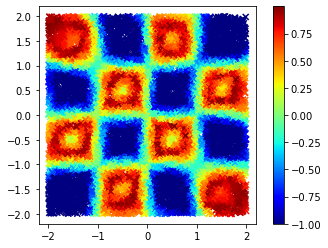

In [30]:
with torch.no_grad():
  samples, _ = batch(10000)
  outputs = network(samples.to(device)).cpu()

pyplot.scatter(samples[:,0], samples[:,1], marker="x", c = outputs, cmap="jet")
pyplot.axis("square")
pyplot.colorbar()